In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from math import sqrt
from numpy import split, array, argmax, tensordot
from numpy.linalg import norm
from itertools import product
from pandas import read_csv, DataFrame
from sklearn.metrics import mean_squared_error, accuracy_score
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed, ConvLSTM2D

In [ ]:
# seq= [df["Out"]]

def normalize(weights):
    result = norm(weights,1)
    if result == 0.0:
        return weghts
    return weights/result
def get_train(seq):
    seq = array(seq)
    X, y = seq[:, 0:2], seq[:,2:4]
    X= X.reshape((len(X), 1, 1))
    return X, y
def get_val(seq):
    seq = array(seq)
    X, y = seq[:, 0:2], seq[:,2:4]
    X= X.reshape((len(X), 1, 1))
    return X, y
def grid_search (members, testX, testy):
    # define weights to consider
    W=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    best_score, best_weights=0.0, None
    # iterate all possible combinations (cartesian product)
    for weights in product (w,repeat=len(members)):
        # skip if all weights are equal
        if len(set(weights)) == 1:
            continue
        # hack, normalize weight vector
        weights = normalize(weights)
        # evaluate weights
        score = evaluate_ensemble(members, weights, testX, testy)
        if score > best_score:
            best_score, best_weights = score,weights
        print('>%s %.3f' % (best_weights, best_score))
    return list(best_weights)
def split_train_dataset(data):
    #split into standard weeks
    train, test = data[0:504], data[504:648]
    # restructure into windows of weekly data
    train=array(split(train, len(train)/24))
    test=array(split(teat, len(test)/24))
    return train, test
def split_val_dataset(data):
    #split into standard weeks
    train, test = data[648:720], data[698:720]
    # restructure into windows of weekly data
    train=array(split(train, len(train)/24))
    test=array(split(teat, len(test)/24))
    return train, test
# convert history into inputs and outputs
import numpy as np
def to_supervised(data, n_input, n_out=720):
    # Convert DataFrame to numpy array
    data_array = data.to_numpy()

    X, y = list(), list()
    in_start = 0

    # Step over the entire history one time step at a time
    for _ in range(len(data_array)):
        # Define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out

        # Ensure we have enough data for this instance
        if out_end <= len(data_array):
            X.append(data_array[in_start:in_end])
            y.append(data_array[in_end:out_end])  # Assuming the target is in the first column

        # Move along one time step
        in_start += 1

    return np.array(X), np.array(y)

In [ ]:
df = read_csv('/content/drive/MyDrive/cleand_data.csv',header=0)
df

,Out,Temp,Temp.1,Hum,Speed,Dir,Speed.1,Dir.1,Bar,Rain,Rate,Temp.2,Hum.1
0,26.5,29.7,26.5,54.0,1.6,NW,6.4,NNW,1003.6,0.0,0.0,35.7,29.0
1,27.4,27.4,26.0,69.0,1.6,W,16.1,N,1003.3,0.0,0.0,35.4,30.0
2,26.8,27.5,26.8,73.0,6.4,NW,17.7,WNW,1003.4,0.0,0.0,35.0,33.0
3,26.3,26.8,26.3,75.0,4.8,N,16.1,NNW,1003.5,0.0,0.0,34.7,36.0
4,25.9,26.3,25.9,76.0,4.8,N,14.5,NW,1003.8,0.0,0.0,34.3,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,17.6,17.6,13.9,62.0,0.0,NNE,0.0,NW,1011.5,0.0,0.0,22.0,49.0
1546,20.8,20.8,17.6,52.0,0.0,NNW,0.0,WNW,1011.9,0.0,0.0,21.8,49.0
1547,23.4,23.4,20.8,47.0,0.0,N,0.0,WNW,1011.8,0.0,0.0,21.7,50.0
1548,24.8,25.0,23.5,47.0,0.0,N,0.0,NW,1011.1,0.0,0.0,21.6,51.0


In [ ]:
s = df.drop(['Dir','Dir.1','Bar  ','Rain','Rate'],axis=1)
s

,Out,Temp,Temp.1,Hum,Speed,Speed.1,Temp.2,Hum.1
0,26.5,29.7,26.5,54.0,1.6,6.4,35.7,29.0
1,27.4,27.4,26.0,69.0,1.6,16.1,35.4,30.0
2,26.8,27.5,26.8,73.0,6.4,17.7,35.0,33.0
3,26.3,26.8,26.3,75.0,4.8,16.1,34.7,36.0
4,25.9,26.3,25.9,76.0,4.8,14.5,34.3,38.0
...,...,...,...,...,...,...,...,...
1545,17.6,17.6,13.9,62.0,0.0,0.0,22.0,49.0
1546,20.8,20.8,17.6,52.0,0.0,0.0,21.8,49.0
1547,23.4,23.4,20.8,47.0,0.0,0.0,21.7,50.0
1548,24.8,25.0,23.5,47.0,0.0,0.0,21.6,51.0


In [ ]:
import pandas as pd
s = s.apply(pd.to_numeric, errors='ignore')
s

,Out,Temp,Temp.1,Hum,Speed,Speed.1,Temp.2,Hum.1
0,26.5,29.7,26.5,54.0,1.6,6.4,35.7,29.0
1,27.4,27.4,26.0,69.0,1.6,16.1,35.4,30.0
2,26.8,27.5,26.8,73.0,6.4,17.7,35.0,33.0
3,26.3,26.8,26.3,75.0,4.8,16.1,34.7,36.0
4,25.9,26.3,25.9,76.0,4.8,14.5,34.3,38.0
...,...,...,...,...,...,...,...,...
1545,17.6,17.6,13.9,62.0,0.0,0.0,22.0,49.0
1546,20.8,20.8,17.6,52.0,0.0,0.0,21.8,49.0
1547,23.4,23.4,20.8,47.0,0.0,0.0,21.7,50.0
1548,24.8,25.0,23.5,47.0,0.0,0.0,21.6,51.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, ConvLSTM2D, Flatten, RepeatVector, TimeDistributed
from tensorflow.keras.utils import to_categorical

In [ ]:
train_X, train_y = to_supervised(s, 8)

# define model parameters
verbose, epochs, batch_size = 1, 5, 64
n_features, n_outputs = train_X.shape[2], train_y.shape[1]
train_X = np.expand_dims(train_X, axis=1)  # Add a new axis at index 1
train_X = np.expand_dims(train_X, axis=2)  # Add another new axis at index 2
train_X = np.expand_dims(train_X, axis=4)  # Add a new axis at index 4
# Check the new shape of train_X
print(train_X.shape)
# reshape input data
train_X = train_X.reshape((train_X.shape[0], 1, 1, len(s.columns), 8))
# train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

# define and compile model for sequence prediction task
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1, 8), activation='relu', input_shape=(1, 1, len(s.columns), n_features)))
model.add(Flatten())
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='rmsprop',metrics=['accuracy'])

# fit the model
model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

(823, 1, 1, 8, 1, 8)


Epoch 1/5
13/13 [==============================] - 23s 1s/step - loss: nan - accuracy: 0.1101
Epoch 2/5
13/13 [==============================] - 19s 1s/step - loss: nan - accuracy: 0.1110
Epoch 3/5
13/13 [==============================] - 14s 1s/step - loss: nan - accuracy: 0.1110
Epoch 4/5
13/13 [==============================] - 14s 1s/step - loss: nan - accuracy: 0.1110
Epoch 5/5
13/13 [==============================] - 14s 1s/step - loss: nan - accuracy: 0.1110


In [ ]:
train_X, train_y = to_supervised(s, 8)

# define model parameters
verbose, epochs, batch_size = 1, 1, 64
n_features, n_outputs = train_X.shape[2], train_y.shape[1]
# train_X = np.expand_dims(train_X, axis=1)  # Add a new axis at index 1
# train_X = np.expand_dims(train_X, axis=2)  # Add another new axis at index 2
# train_X = np.expand_dims(train_X, axis=4)  # Add a new axis at index 4
# Check the new shape of train_X
print(train_X.shape)
# reshape input data
train_X = train_X.reshape((train_X.shape[0], 1, 1, len(s.columns), 8))
# train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

# define and compile model for sequence prediction task
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1, 8), activation='relu', input_shape=(1, 1, len(s.columns), n_features)))
model.add(Flatten())
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='rmsprop',metrics=['accuracy'])

# fit the model
model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

(823, 8, 8)
13/13 [==============================] - 18s 1s/step - loss: nan - accuracy: 0.1059


In [ ]:
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])
model.fit(train_X, train_y, epochs=10, batch_size=32, verbose=verbose)

Epoch 1/10
26/26 [==============================] - 29s 918ms/step - loss: nan - accuracy: 0.1110
Epoch 2/10
26/26 [==============================] - 25s 934ms/step - loss: nan - accuracy: 0.1110
Epoch 3/10
14/26 [===============>..............] - ETA: 13s - loss: nan - accuracy: 0.1135

KeyboardInterrupt: 

In [ ]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.initializers import glorot_uniform
# n_features=8
# train_X, train_y = to_supervised(s, n_features)
# Define input shape
# n_features, n_outputs = train_X.shape[2], train_y.shape[1]
# input_shape = (1, 1, len(s.columns), n_features)

# Initialize the model
# model = Sequential()

# # Add ConvLSTM2D layer with proper initialization
# model.add(ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', input_shape=input_shape,
#                      kernel_initializer=glorot_uniform(seed=42)))

# # Add Batch Normalization
# model.add(BatchNormalization())

# # Add Flatten layer
# model.add(Flatten())

# # Add RepeatVector
# model.add(RepeatVector(n_outputs))

# # Add LSTM layer
# model.add(LSTM(200, activation='relu', return_sequences=True))

# # Add TimeDistributed Dense layer with ReLU activation
# model.add(TimeDistributed(Dense(100, activation='relu')))

# # Add TimeDistributed Dense output layer
# model.add(TimeDistributed(Dense(1)))

# Compile the model with RMSprop optimizer and appropriate learning rate
optimizer = RMSprop(learning_rate=0.001)  # Adjust learning rate as needed
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
model.fit(train_X, train_y, epochs=10, batch_size=32, verbose=verbose)

Epoch 1/10
26/26 [==============================] - 28s 956ms/step - loss: nan - accuracy: 0.1110
Epoch 2/10
26/26 [==============================] - 25s 955ms/step - loss: nan - accuracy: 0.1110
Epoch 3/10
 4/26 [===>..........................] - ETA: 18s - loss: nan - accuracy: 0.1051

KeyboardInterrupt: 

In [ ]:
optimizer = RMSprop(learning_rate=0.001)  # Adjust learning rate as needed
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
model.fit(train_X, train_y, epochs=10, batch_size=32, verbose=verbose)

Epoch 1/10
26/26 [==============================] - 30s 1s/step - loss: nan - accuracy: 0.1110
Epoch 2/10
26/26 [==============================] - 25s 972ms/step - loss: nan - accuracy: 0.1110
Epoch 3/10
26/26 [==============================] - 26s 1s/step - loss: nan - accuracy: 0.1110
Epoch 4/10
26/26 [==============================] - 25s 957ms/step - loss: nan - accuracy: 0.1110
Epoch 5/10
26/26 [==============================] - 26s 982ms/step - loss: nan - accuracy: 0.1110
Epoch 6/10
26/26 [==============================] - 44s 2s/step - loss: nan - accuracy: 0.1110
Epoch 7/10
26/26 [==============================] - 28s 1s/step - loss: nan - accuracy: 0.1110
Epoch 8/10
26/26 [==============================] - 36s 1s/step - loss: nan - accuracy: 0.1110
Epoch 9/10
26/26 [==============================] - 25s 960ms/step - loss: nan - accuracy: 0.1110
Epoch 10/10
26/26 [==============================] - 25s 956ms/step - loss: nan - accuracy: 0.1110


In [ ]:
df = df.drop(['Dir','Dir.1','Bar  ','Rain','Rate'],axis=1)
df

,Out,Temp,Temp.1,Hum,Speed,Speed.1,Temp.2,Hum.1
0,26.5,29.7,26.5,54.0,1.6,6.4,35.7,29.0
1,27.4,27.4,26.0,69.0,1.6,16.1,35.4,30.0
2,26.8,27.5,26.8,73.0,6.4,17.7,35.0,33.0
3,26.3,26.8,26.3,75.0,4.8,16.1,34.7,36.0
4,25.9,26.3,25.9,76.0,4.8,14.5,34.3,38.0
...,...,...,...,...,...,...,...,...
1545,17.6,17.6,13.9,62.0,0.0,0.0,22.0,49.0
1546,20.8,20.8,17.6,52.0,0.0,0.0,21.8,49.0
1547,23.4,23.4,20.8,47.0,0.0,0.0,21.7,50.0
1548,24.8,25.0,23.5,47.0,0.0,0.0,21.6,51.0


In [ ]:
df

,Out,Temp,Temp.1,Hum,Speed,Speed.1,Temp.2,Hum.1
0,26.5,29.7,26.5,54.0,1.6,6.4,35.7,29.0
1,27.4,27.4,26.0,69.0,1.6,16.1,35.4,30.0
2,26.8,27.5,26.8,73.0,6.4,17.7,35.0,33.0
3,26.3,26.8,26.3,75.0,4.8,16.1,34.7,36.0
4,25.9,26.3,25.9,76.0,4.8,14.5,34.3,38.0
...,...,...,...,...,...,...,...,...
1545,17.6,17.6,13.9,62.0,0.0,0.0,22.0,49.0
1546,20.8,20.8,17.6,52.0,0.0,0.0,21.8,49.0
1547,23.4,23.4,20.8,47.0,0.0,0.0,21.7,50.0
1548,24.8,25.0,23.5,47.0,0.0,0.0,21.6,51.0


In [ ]:
s = df.iloc[:1085]
s

,Out,Temp,Temp.1,Hum,Speed,Speed.1,Temp.2,Hum.1
0,26.5,29.7,26.5,54.0,1.6,6.4,35.7,29.0
1,27.4,27.4,26.0,69.0,1.6,16.1,35.4,30.0
2,26.8,27.5,26.8,73.0,6.4,17.7,35.0,33.0
3,26.3,26.8,26.3,75.0,4.8,16.1,34.7,36.0
4,25.9,26.3,25.9,76.0,4.8,14.5,34.3,38.0
...,...,...,...,...,...,...,...,...
1080,22.9,25.1,22.9,59.0,0.0,0.0,31.4,40.0
1081,22.2,22.2,21.9,63.0,0.0,0.0,31.1,41.0
1082,21.3,22.4,21.2,65.0,0.0,0.0,30.8,42.0
1083,21.2,21.3,21.2,68.0,0.0,0.0,30.5,43.0


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' is your DataFrame with columns: 'Out', 'Temp', 'Temp.1', 'Hum', 'Speed', 'Speed.1', 'Temp.2', 'Hum.1'

# Convert DataFrame to numpy array
data = df.values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define window size for time series data
window_size = 10  # You can adjust this value based on the length of your sequences

# Function to create sequences for input data
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :])  # Each element of X is a sequence of length 'window_size'
        y.append(data[i+window_size, 0])    # Corresponding y value is the 'Out' value following the sequence
    return np.array(X), np.array(y)

# Create sequences for input data
X, y = create_sequences(scaled_data, window_size)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 8)),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
39/39 [==============================] - 2s 20ms/step - loss: 0.0391 - accuracy: 0.0000e+00 - val_loss: 0.0249 - val_accuracy: 0.0032
Epoch 2/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0154 - accuracy: 0.0000e+00 - val_loss: 0.0221 - val_accuracy: 0.0032
Epoch 3/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0097 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0032
Epoch 4/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0078 - accuracy: 8.1169e-04 - val_loss: 0.0134 - val_accuracy: 0.0032
Epoch 5/50
39/39 [==============================] - 1s 14ms/step - loss: 0.0072 - accuracy: 8.1169e-04 - val_loss: 0.0105 - val_accuracy: 0.0032
Epoch 6/50
39/39 [==============================] - 1s 13ms/step - loss: 0.0062 - accuracy: 8.1169e-04 - val_loss: 0.0090 - val_accuracy: 0.0032
Epoch 7/50
39/39 [==============================] - 1s 24ms/step - loss: 0.0060 - accuracy: 8.1169e-04 - val_loss: 0.0107 - val_ac

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
27/27 [==============================] - 3s 23ms/step - loss: 0.0037 - accuracy: 0.0012 - val_loss: 0.0102 - val_accuracy: 0.0047
Epoch 2/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0033 - accuracy: 0.0012 - val_loss: 0.0121 - val_accuracy: 0.0047
Epoch 3/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0033 - accuracy: 0.0012 - val_loss: 0.0154 - val_accuracy: 0.0047
Epoch 4/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0034 - accuracy: 0.0012 - val_loss: 0.0173 - val_accuracy: 0.0047
Epoch 5/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0036 - accuracy: 0.0012 - val_loss: 0.0123 - val_accuracy: 0.0047
Epoch 6/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0033 - accuracy: 0.0012 - val_loss: 0.0131 - val_accuracy: 0.0047
Epoch 7/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0031 - accuracy: 0.0012 - val_loss: 0.0149 - val_accuracy: 0.0047
Epoch 8/50
27

In [ ]:
los = model.evaluate(X_test,y_test)
los

10/10 [==============================] - 0s 5ms/step - loss: 0.0085 - accuracy: 0.0032


[0.008486226201057434, 0.003246753243729472]

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
import keras
# Build LSTM model with increased complexity
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, 8)),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile the model with a lower learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

# Increase the number of epochs and monitor performance on validation data
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/100
39/39 [==============================] - 7s 62ms/step - loss: 0.0413 - accuracy: 0.0000e+00 - val_loss: 0.0252 - val_accuracy: 0.0032
Epoch 2/100
39/39 [==============================] - 1s 27ms/step - loss: 0.0191 - accuracy: 0.0000e+00 - val_loss: 0.0262 - val_accuracy: 0.0032
Epoch 3/100
39/39 [==============================] - 1s 27ms/step - loss: 0.0130 - accuracy: 0.0000e+00 - val_loss: 0.0175 - val_accuracy: 0.0032
Epoch 4/100
39/39 [==============================] - 1s 28ms/step - loss: 0.0119 - accuracy: 0.0000e+00 - val_loss: 0.0140 - val_accuracy: 0.0032
Epoch 5/100
39/39 [==============================] - 1s 26ms/step - loss: 0.0102 - accuracy: 0.0000e+00 - val_loss: 0.0096 - val_accuracy: 0.0032
Epoch 6/100
39/39 [==============================] - 1s 28ms/step - loss: 0.0088 - accuracy: 0.0000e+00 - val_loss: 0.0098 - val_accuracy: 0.0032
Epoch 7/100
39/39 [==============================] - 1s 27ms/step - loss: 0.0071 - accuracy: 8.1169e-04 - val_loss: 0.0127 -

In [ ]:
def generate_forecasts(model, input_data, window_size, forecast_steps):
    forecasts = []
    current_sequence = input_data[-window_size:, :]  # Get the last sequence from input data
    for _ in range(forecast_steps):
        # Reshape current sequence to match model input shape
        current_sequence_reshaped = np.reshape(current_sequence, (1, window_size, input_data.shape[1]))
        # Predict the next value
        next_value = model.predict(current_sequence_reshaped)[0, 0]
        # Repeat the predicted value for each feature in the sequence
        next_value_repeated = np.repeat(next_value, input_data.shape[1])
        # Append the repeated predicted value to forecasts
        forecasts.append(next_value_repeated)
        # Update current sequence by removing the first row and appending the predicted value
        current_sequence = np.vstack([current_sequence[1:, :], next_value_repeated])
    return forecasts

# Example usage:
forecast_steps = 720  # Number of forecast steps
forecasts = generate_forecasts(model, scaled_data, window_size, forecast_steps)

# Inverse transform the forecasts to get the actual values
forecasts = scaler.inverse_transform(forecasts)

# Display the forecasts
print(forecasts)

1/1 [==============================] - 0s 19ms/step
[[30.58629045 31.09415407 30.40173931 ... 18.82421665 31.19665947
  53.60681915]
 [29.43900552 29.97953206 29.26670297 ... 17.57486011 30.5597326
  51.97367334]
 [26.22690133 26.85887567 26.0888917  ... 14.07698151 28.77650038
  47.40128303]
 ...
 [15.58222383 16.51724948 15.55785845 ...  2.48526865 22.8669997
  32.24871719]
 [15.58222383 16.51724948 15.55785845 ...  2.48526865 22.8669997
  32.24871719]
 [15.58222362 16.51724928 15.55785824 ...  2.48526842 22.86699959
  32.24871689]]


In [ ]:
forecasts[0]

array([30.58629045, 31.09415407, 30.40173931, 62.29227448,  6.95142641,
       18.82421665, 31.19665947, 53.60681915])

In [ ]:
df

,Out,Temp,Temp.1,Hum,Speed,Speed.1,Temp.2,Hum.1
0,26.5,29.7,26.5,54.0,1.6,6.4,35.7,29.0
1,27.4,27.4,26.0,69.0,1.6,16.1,35.4,30.0
2,26.8,27.5,26.8,73.0,6.4,17.7,35.0,33.0
3,26.3,26.8,26.3,75.0,4.8,16.1,34.7,36.0
4,25.9,26.3,25.9,76.0,4.8,14.5,34.3,38.0
...,...,...,...,...,...,...,...,...
1545,17.6,17.6,13.9,62.0,0.0,0.0,22.0,49.0
1546,20.8,20.8,17.6,52.0,0.0,0.0,21.8,49.0
1547,23.4,23.4,20.8,47.0,0.0,0.0,21.7,50.0
1548,24.8,25.0,23.5,47.0,0.0,0.0,21.6,51.0


In [ ]:
import pandas as pd

# Convert the forecasts to a DataFrame
forecast_df = pd.DataFrame(forecasts, columns=df.columns)

# Display the forecast DataFrame
forecast_df

,Out,Temp,Temp.1,Hum,Speed,Speed.1,Temp.2,Hum.1
0,30.586290,31.094154,30.401739,62.292274,6.951426,18.824217,31.196659,53.606819
1,29.439006,29.979532,29.266703,59.352612,6.490063,17.574860,30.559733,51.973673
2,26.226901,26.858876,26.088892,51.122309,5.198362,14.076982,28.776500,47.401283
3,23.578274,24.285654,23.468541,44.335791,4.133256,11.192711,27.306088,43.630995
4,21.617300,22.380509,21.528504,39.311232,3.344679,9.057274,26.217434,40.839573
...,...,...,...,...,...,...,...,...
715,15.582224,16.517249,15.557858,23.847691,0.917763,2.485269,22.867000,32.248717
716,15.582224,16.517249,15.557858,23.847691,0.917763,2.485269,22.867000,32.248717
717,15.582224,16.517249,15.557858,23.847691,0.917763,2.485269,22.867000,32.248717
718,15.582224,16.517249,15.557858,23.847691,0.917763,2.485269,22.867000,32.248717


In [ ]:
# Save the DataFrame
forecast_df.to_csv("101.csv",index=False)

In [1]:
import pandas as pd

In [ ]:
forecast_steps = 744  # Number of forecast steps
forecasts = generate_forecasts(model, scaled_data, window_size, forecast_steps)

# Inverse transform the forecasts to get the actual values
forecasts = scaler.inverse_transform(forecasts)

1/1 [==============================] - 0s 19ms/step


In [ ]:
# Convert the forecasts to a DataFrame
forecast_df = pd.DataFrame(forecasts, columns=df.columns)

# Display the forecast DataFrame
forecast_df

,Out,Temp,Temp.1,Hum,Speed,Speed.1,Temp.2,Hum.1
0,30.586290,31.094154,30.401739,62.292274,6.951426,18.824217,31.196659,53.606819
1,29.439006,29.979532,29.266703,59.352612,6.490063,17.574860,30.559733,51.973673
2,26.226901,26.858876,26.088892,51.122309,5.198362,14.076982,28.776500,47.401283
3,23.578274,24.285654,23.468541,44.335791,4.133256,11.192711,27.306088,43.630995
4,21.617300,22.380509,21.528504,39.311232,3.344679,9.057274,26.217434,40.839573
...,...,...,...,...,...,...,...,...
739,15.582224,16.517250,15.557859,23.847691,0.917763,2.485269,22.867000,32.248717
740,15.582224,16.517249,15.557858,23.847691,0.917763,2.485269,22.867000,32.248717
741,15.582224,16.517250,15.557859,23.847691,0.917763,2.485269,22.867000,32.248717
742,15.582224,16.517249,15.557858,23.847691,0.917763,2.485269,22.867000,32.248717


In [ ]:
# Save the DataFrame
forecast_df.to_csv("last_10.csv",index=False)

In [4]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/last_10.csv")
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Out,Temp,Temp.1,Hum,Speed,Speed.1,Temp.2,Hum.1
0,30.586290,31.094154,30.401739,62.292274,6.951426,18.824217,31.196659,53.606819
1,29.439006,29.979532,29.266703,59.352612,6.490063,17.574860,30.559733,51.973673
2,26.226901,26.858876,26.088892,51.122309,5.198362,14.076982,28.776500,47.401283
3,23.578274,24.285654,23.468541,44.335791,4.133256,11.192711,27.306088,43.630995
4,21.617300,22.380509,21.528504,39.311232,3.344679,9.057274,26.217434,40.839573
...,...,...,...,...,...,...,...,...
739,15.582224,16.517250,15.557859,23.847691,0.917763,2.485269,22.867000,32.248717
740,15.582224,16.517249,15.557858,23.847691,0.917763,2.485269,22.867000,32.248717
741,15.582224,16.517250,15.557859,23.847691,0.917763,2.485269,22.867000,32.248717
742,15.582224,16.517249,15.557858,23.847691,0.917763,2.485269,22.867000,32.248717


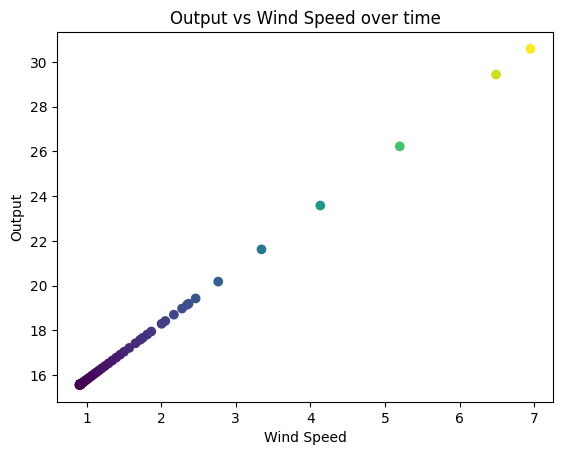

In [24]:
import matplotlib.pyplot as plt
plt.scatter(df['Speed'], df['Out'], c=df['Speed'])
plt.xlabel('Wind Speed')
plt.ylabel('Output')
_ = plt.title('Output vs Wind Speed over time')

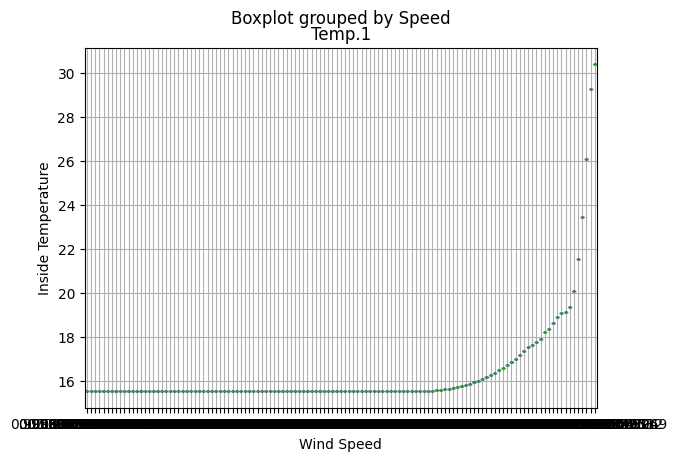

In [22]:
import matplotlib.pyplot as plt
df.boxplot('Temp.1', by='Speed')
plt.xlabel('Wind Speed')
_ = plt.ylabel('Inside Temperature')

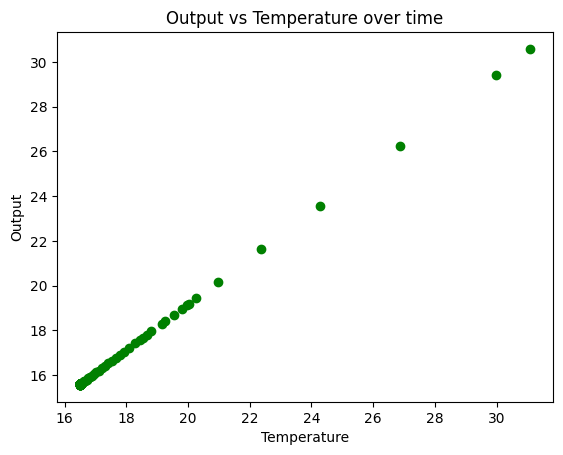

In [20]:
import matplotlib.pyplot as plt
plt.plot(df['Temp'], df['Out'], color='g', marker='o', linestyle='None')
plt.xlabel('Temperature')
plt.ylabel('Output')
_ = plt.title('Output vs Temperature over time')

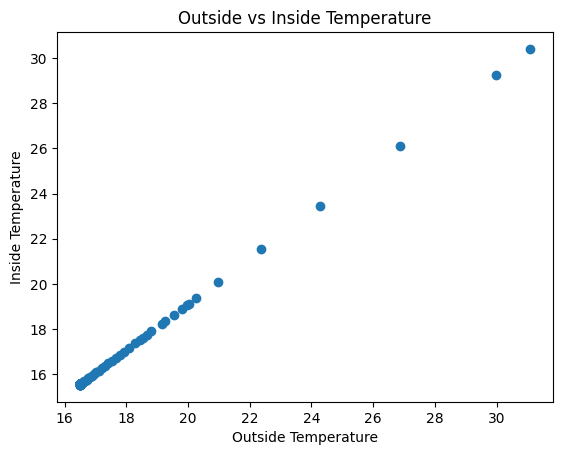

In [18]:
import matplotlib.pyplot as plt
plt.scatter(df['Temp'], df['Temp.1'])
plt.xlabel('Outside Temperature')
plt.ylabel('Inside Temperature')
_ = plt.title('Outside vs Inside Temperature')

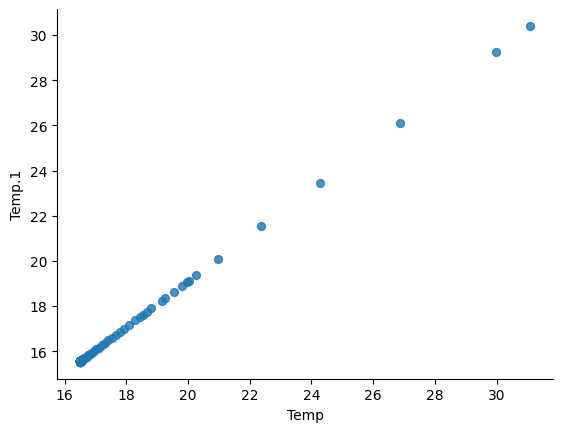

In [16]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Temp', y='Temp.1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

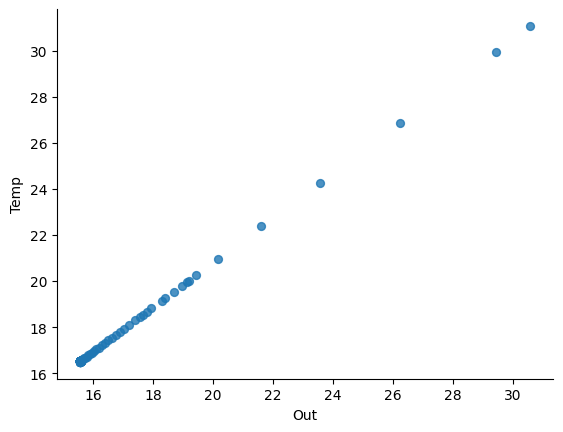

In [14]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Out', y='Temp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

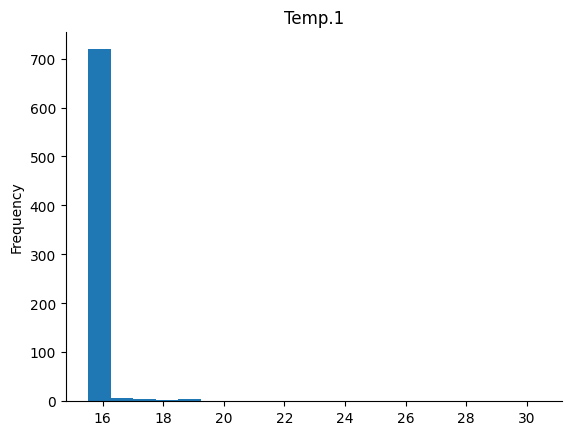

In [10]:
from matplotlib import pyplot as plt
df['Temp.1'].plot(kind='hist', bins=20, title='Temp.1')
plt.gca().spines[['top', 'right',]].set_visible(False)

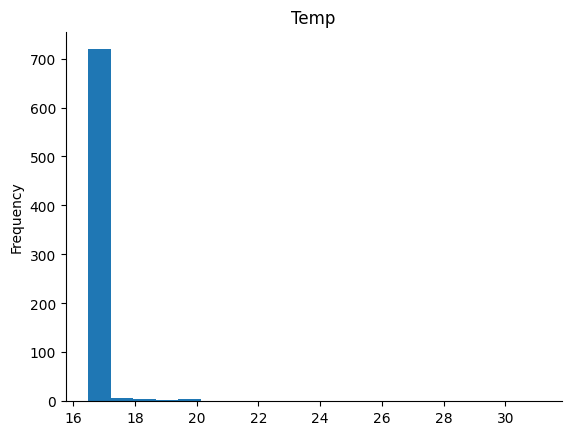

In [8]:
from matplotlib import pyplot as plt
df['Temp'].plot(kind='hist', bins=20, title='Temp')
plt.gca().spines[['top', 'right',]].set_visible(False)

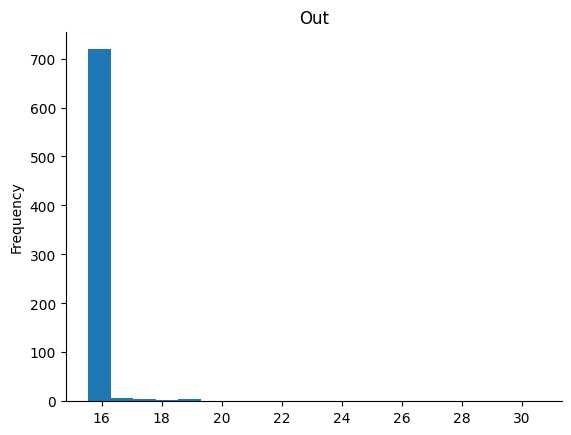

In [6]:
from matplotlib import pyplot as plt
df['Out'].plot(kind='hist', bins=20, title='Out')
plt.gca().spines[['top', 'right',]].set_visible(False)